# Digital-to-Analog Converter Scan

### Introduction
<p style='text-align: justify'>
The Digital Analog Converter (DAC) scan is a measurement performed on the front-end electronics. A known charge, defined as a number of pulses of equal amplitudes, is injected. The calibration is performed using the mentioned DAC which generates an analog signal of known amplitude. If the injected charge is lower than the established discriminator threshold, there is no triggering and the output is equal to 0. By sending increasingly higher amplitudes over time, at certain point, the injected charge exceeds the discriminator threshold. All the pulses at the input are then recorded and for each one the output equal to 1 is produced. As a result, a number of detected signals as a function of the DAC voltage is observed. Theoretically, a perfect step distribution should be obtained but when taking into account the electronic noise, the shape tends towards the letter "S" (S-Curve). The derivative of an S-Curve is a Gaussian distribution where its centre is a transition point, which corresponds to the threshold equivalent input charge, and its width is a noise of a charge. One of the methods used to acquire both of these parameters is by fitting an S-Curve with a translated error function (erf). The standard erf is defined as:
$$erf(x)=\frac{2}{\sqrt\pi}\int^x_0e^{-t^2}dt$$
and the translated erf is determined as:
$$f(x)=\frac{1}{2}[1+erf(\frac{x-x_{t}}{\sigma})]$$
where $x_{t}$ is a transition point at which the distribution reaches half of its height and the $\sigma$ is the width of the curve slope that is equivalent to noise.

The purpose of this analysis is to calculate both parameters to get an information about the intensity of the SIN to the signal for each pixel of Multi-Anode Photomultiplier Tubes (MaPMTs).

    
The following notebook analyses the Elementary Cell of R-type and H-type in terms of SIN. It saves all the generated plots in the \output file. As there are a lot of plots, only the first plot is shown in the following notebook.
    
</p>

### Procedure
1. Extract the mapping data.
2. Extract the measurement data.
3. Calculate $x_{t}$ and $\sigma$ for each channel.
4. Reorganize the dataframe.
5. Exclude disabled channels.
6. Fit the DAC scan data using translated erf and calculate $x_{t}$ and $\sigma$ for each channel.
7. Produce 1D histograms of $x_{t}$ and $\sigma$ for all the channels.

### Libraries
Importing essential libraries: numpy, pandas, matplotlib and seaborn.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

from scipy.optimize import curve_fit
from scipy import special

### Load selection
Load refers to a complete measurement of 4 Elementary Cells. The data has been uploaded for 10 loads from two stations.  
- To select a station, provide "S1" or "S2".
- To select a load, provide a number from "0001" up to "00005".
- To select the type of an Elementary Cell, provide either "R" (for loads "0001", "0002" and "0003") or "H" for (loads "0004" and "0005").

In [2]:
station = "S1"
load = "0001"
ectype = "R"

### Mapping data
Extraction of the mapping data for an Elementary Cell of R-Type and H-Type. Identification is required to be included in the graphs as there are 1024 channels for R-type and 256 channels for H-type.

In [3]:
ECs_df = pd.DataFrame()

In [4]:
def Mapping(ectype):
    
    map_IDs = []
    map_ECs = []
    map_PMTs = []
    map_anodes = []
    
    if ectype == 'R':
        with open('mapping/R_Map.txt') as file:
            map_data = file.readlines()[1:]
    elif ectype == "H":
        with open('mapping/H_Map.txt') as file:
            map_data = file.readlines()[1:]
    else:
        raise ValueError('Wrong type of an Elementary Cell.')

    for i in range(0, len(map_data)):
        map_channel = map_data[i].split(' ')

        map_ID = ' '.join(map_channel[0:4])
        map_IDs.append(map_ID)

        map_EC = int(map_channel[4])
        map_ECs.append(map_EC)

        if ectype == 'R':
            map_PMT = map_channel[5]
            map_PMTs.append(map_PMT)
            
            map_anode = int(map_channel[6])
            map_anodes.append(map_anode)
        elif ectype == 'H':
            map_anode = int(map_channel[5])
            map_anodes.append(map_anode)

    map_IDs = np.array(map_IDs)
    map_ECs = np.array(map_ECs)
    if ectype == 'R':
        map_PMTs = np.array(map_PMTs)
    map_anodes = np.array(map_anodes)

    ECs_df['ID'] = map_IDs
    ECs_df['EC'] = map_ECs
    if ectype == 'R':
        ECs_df['PMT'] = map_PMTs
    ECs_df['Anode'] = map_anodes

In [5]:
Mapping(ectype)

In [6]:
ECs_df

,ID,EC,PMT,Anode
0,0 0 0 0,3,D,37
1,0 0 0 1,3,D,45
2,0 0 0 2,3,D,38
3,0 0 0 3,3,D,46
4,0 0 0 4,3,D,39
...,...,...,...,...
1019,7 1 7 3,2,B,6
1020,7 1 7 4,2,B,15
1021,7 1 7 5,2,B,7
1022,7 1 7 6,2,B,16


### Measurement data
Extraction of the measurement data for the specified load. Unfortunately, the order of measurement data does not match the mapping data hence additional ordering action is required.

In [7]:
temp_df = pd.DataFrame()

In [8]:
def Data(station, load, ectype):
    
    with open(f'data/station-{station[1]}/Load_{load}_{ectype}_{station}/SCURVE_cfg30A.txt') as file:
        datax = [line.strip() for line in file if line.strip()]
        data = datax[8:]
    
    IDs_UART = []
    IDs_FEB = []
    IDs_CHIP = []
    DAC_steps = []
    CH0_hitcounts = []
    CH1_hitcounts = []
    CH2_hitcounts = []
    CH3_hitcounts = []
    CH4_hitcounts = []
    CH5_hitcounts = []
    CH6_hitcounts = []
    CH7_hitcounts = []
    
    for i in range(0, len(data)):
        data_channel = data[i]
        
        ID_UART = data_channel.split(" ")[0]
        IDs_UART.append(ID_UART)
        
        ID_FEB = data_channel.split(" ")[1]
        IDs_FEB.append(ID_FEB)
        
        ID_CHIP = data_channel.split(" ")[2]
        IDs_CHIP.append(ID_CHIP)
        
        DAC_step = data_channel.split(" ")[3]
        DAC_steps.append(DAC_step)
    
        CH0_hitcount = int(data_channel.split(" ")[4])
        CH0_hitcounts.append(CH0_hitcount)
            
        CH1_hitcount = int(data_channel.split(" ")[5])
        CH1_hitcounts.append(CH1_hitcount)
        
        CH2_hitcount = int(data_channel.split(" ")[6])
        CH2_hitcounts.append(CH2_hitcount)
        
        CH3_hitcount = int(data_channel.split(" ")[7])
        CH3_hitcounts.append(CH3_hitcount)
        
        CH4_hitcount = int(data_channel.split(" ")[8])
        CH4_hitcounts.append(CH4_hitcount)
    
        CH5_hitcount = int(data_channel.split(" ")[9])
        CH5_hitcounts.append(CH5_hitcount)
        
        CH6_hitcount = int(data_channel.split(" ")[10])
        CH6_hitcounts.append(CH6_hitcount)
        
        CH7_hitcount = int(data_channel.split(" ")[11])
        CH7_hitcounts.append(CH7_hitcount)
        
    IDs_UART=np.array(IDs_UART)
    IDs_FEB=np.array(IDs_FEB)
    IDs_CHIP=np.array(IDs_CHIP)
            
    DAC_steps=np.array(DAC_steps)
    
    CH0_hitcounts=np.array(CH0_hitcounts)
    CH1_hitcounts=np.array(CH1_hitcounts)
    CH2_hitcounts=np.array(CH2_hitcounts)
    CH3_hitcounts=np.array(CH3_hitcounts)
    CH4_hitcounts=np.array(CH4_hitcounts)
    CH5_hitcounts=np.array(CH5_hitcounts)
    CH6_hitcounts=np.array(CH6_hitcounts)
    CH7_hitcounts=np.array(CH7_hitcounts)
                
    temp_df['ID_UART'] = IDs_UART.tolist()
    temp_df['ID_FEB'] = IDs_FEB.tolist()
    temp_df['ID_CHIP'] = IDs_CHIP.tolist()
            
    temp_df['DAC_step'] = DAC_steps
    
    temp_df['CH0_hitcounts'] = CH0_hitcounts
    temp_df['CH1_hitcounts'] = CH1_hitcounts
    temp_df['CH2_hitcounts'] = CH2_hitcounts
    temp_df['CH3_hitcounts'] = CH3_hitcounts
    temp_df['CH4_hitcounts'] = CH4_hitcounts
    temp_df['CH5_hitcounts'] = CH5_hitcounts
    temp_df['CH6_hitcounts'] = CH6_hitcounts
    temp_df['CH7_hitcounts'] = CH7_hitcounts

In [9]:
Data(station, load, ectype)

In [10]:
temp_df

,ID_UART,ID_FEB,ID_CHIP,DAC_step,CH0_hitcounts,CH1_hitcounts,CH2_hitcounts,CH3_hitcounts,CH4_hitcounts,CH5_hitcounts,CH6_hitcounts,CH7_hitcounts
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,0,0
3,0,0,3,0,0,0,0,0,0,0,0,0
4,0,0,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
76923,7,1,3,600,1000,1000,1000,1000,1000,1000,1000,1000
76924,7,1,4,600,1000,1000,1000,1000,1000,1000,1000,1000
76925,7,1,5,600,1000,1000,1000,1000,1000,1000,1000,1000
76926,7,1,6,600,1000,1000,1000,1000,1000,1000,1000,1000


### Reorganization
The temporary dataframe consists of more than 70k rows! Let's reorganize the dataframe so the rows correspond to channels (1024 for R-type and 256 for H-type) and concatenate with the main dataframe ECs_df.

In [11]:
ordered_df = pd.DataFrame()

In [12]:
for UART in range(8):
    for FEB in range(2):
        for CHIP in range(8):
            for CHANNEL in range(8):
                hitcount = list(temp_df[(temp_df['ID_UART']==str(UART)) & (temp_df['ID_FEB']==str(FEB)) & (temp_df['ID_CHIP']==str(CHIP))][f'CH{CHANNEL}_hitcounts'].values)
                dict_temp={'Channel ID': list([UART, FEB, CHIP, CHANNEL]), 'Hitcount': hitcount} 
                ordered_df=ordered_df.append(dict_temp, ignore_index=True)

In [13]:
ordered_df

,Channel ID,Hitcount
0,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1019,"[7, 1, 7, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1020,"[7, 1, 7, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1021,"[7, 1, 7, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1022,"[7, 1, 7, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
ECs_df = pd.concat([ECs_df, ordered_df], axis=1)

In [15]:
ECs_df

,ID,EC,PMT,Anode,Channel ID,Hitcount
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Exclusion of disabled channels
For the ECs of H-type, half of the rows are empty as the channels are turned off. Empty rows are indicated by anodes equal to 0. For the ECs of R-type, no cleaning is required as all the channels are active (but the function can be run anyway).

In [16]:
def Empty_Anodes_Delete():
    ECs_df.drop(ECs_df[ECs_df['Anode']==0].index, inplace=True)
    ECs_df.reset_index(drop=True, inplace=True)

In [17]:
Empty_Anodes_Delete()

In [18]:
ECs_df

,ID,EC,PMT,Anode,Channel ID,Hitcount
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Fitting & Plotting
...

In [19]:
def fit_function(x, xt, sigma):
    return 1000*1/2*(1+special.erf((x-xt)/(np.sqrt(2)*sigma)))

In [20]:
def Fit_Parameters(station, load, ectype, analysis):

    xts = []
    sigmas = []
    steps = range(0,601)
    
    for i in range(0, len(ECs_df)):
        hitcounts = ECs_df['Hitcount'][i]
        
        popt, pcov = curve_fit(fit_function, steps, hitcounts, [500.0, 2.0])
    
        xt = popt[0]
        xts.append(xt)
        
        sigma = popt[1]
        sigmas.append(sigma)
    
    ECs_df['Transition'] = xts
    ECs_df['Noise'] = sigmas

In [21]:
Fit_Parameters(station, load, ectype, 'S_Curve')

In [22]:
ECs_df

,ID,EC,PMT,Anode,Channel ID,Hitcount,Transition,Noise
0,0 0 0 0,3,D,37,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",91.416134,1.277827
1,0 0 0 1,3,D,45,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",104.190281,1.375670
2,0 0 0 2,3,D,38,"[0, 0, 0, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",117.348194,1.350435
3,0 0 0 3,3,D,46,"[0, 0, 0, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",108.277843,1.432308
4,0 0 0 4,3,D,39,"[0, 0, 0, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",62.451511,1.367047
...,...,...,...,...,...,...,...,...
1019,7 1 7 3,2,B,6,"[7, 1, 7, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",206.131469,2.279951
1020,7 1 7 4,2,B,15,"[7, 1, 7, 4]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",104.085475,1.469075
1021,7 1 7 5,2,B,7,"[7, 1, 7, 5]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",149.949691,1.669693
1022,7 1 7 6,2,B,16,"[7, 1, 7, 6]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116.153526,1.185843


In [23]:
def Fit_Plotting(station, load, ectype, analysis):

    steps = range(0,601)
    
    for EC in range(0, 4):
        if ectype=='R':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'PMT', 'Anode']).reset_index(drop=True)
        elif ectype=='H':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'Anode']).reset_index(drop=True)
        else:
            raise ValueError('Wrong type of an Elementary Cell.')
    
        with PdfPages(f"output/{station}_{ectype}_{load}_DAC_Scan_{analysis}_EC_{EC}.pdf") as pdf:
            for i in range(0, len(EC_df)):
                fig = plt.figure(figsize=(12,9))
                ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

                if ectype=='R':
                    ax.set_title(f'S-Curve of PMT: {EC_df.loc[i, "PMT"]} Anode: {EC_df.loc[i, "Anode"]} (UART: {EC_df.loc[i, "ID"][0]} FEB: {EC_df.loc[i, "ID"][2]} CHIP: {EC_df.loc[i, "ID"][4]} CHANNEL: {EC_df.loc[i, "ID"][6]})')
                elif ectype=='H':
                    ax.set_title(f'S-Curve of Anode: {EC_df.loc[i, "Anode"]} (UART: {EC_df.loc[i, "ID"][0]} FEB: {EC_df.loc[i, "ID"][2]} CHIP: {EC_df.loc[i, "ID"][4]} CHANNEL: {EC_df.loc[i, "ID"][6]})')        
                
                ax.set_xlabel('DAC Steps (0-600)')
                ax.set_ylabel('Counts')                 
                                 
                hitcounts = EC_df['Hitcount'][i]
                plt.plot(steps, hitcounts)

                popt, pcov = curve_fit(fit_function, steps, hitcounts, [500.0, 2.0])

                plt.plot(steps, fit_function(steps, *popt), 'r-', label='fitting parameters'+':\n'+r'$x_{t}$=%5.3f, $\sigma$=%5.3f' % tuple(popt))
                plt.legend(loc='best', bbox_to_anchor=(0.5, 0, 0.5, 0.8), fontsize='xx-large')
                                 
                pdf.savefig()
                plt.rcParams.update({'figure.max_open_warning': 0})
                
                if (EC==0) & (i==0):
                    plt.show()
                else:
                    plt.close()

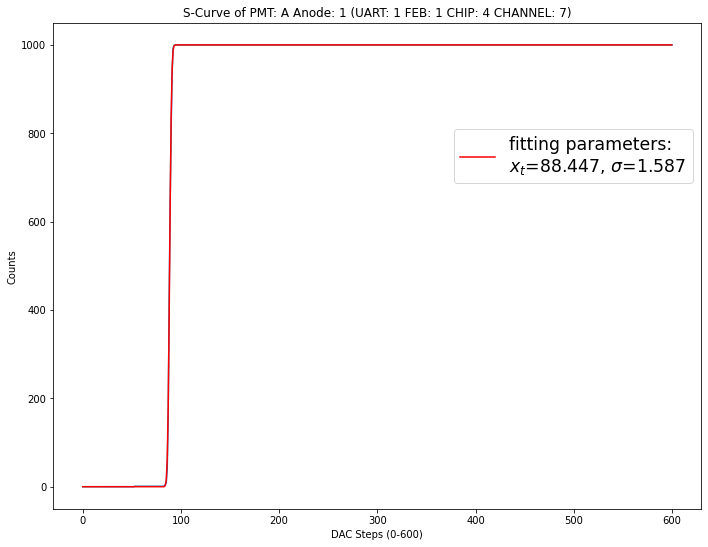

In [24]:
Fit_Plotting(station, load, ectype, 'S_Curve')

### 1D Histograms
The 1D histograms give an insight of the intensity of the SIN for the whole load (4 ECs). Two kinds of histograms can be produced:
- $SIN_{fraction}$ $\;\;\;\;\;\;\;\;\;\;$ (analysis = 'SIN_Fraction'),
- $SIN_{ratio}$ $\;\;\;\;\;\;\;\;\;\;\;\;\;$ (anaysis = 'SN_Ratio').

In [47]:
def Histograms_1D(station, load, ectype, analysis):
    
    if analysis == 'Transition':
        to_title = 'Transition'
        x_label = 'DAC Steps'
        my_bins = 100
#         limits = [0, 100]
    elif analysis == 'Noise':
        to_title = 'Noise'
        x_label = 'DAC Steps'
        my_bins = 100
#         limits = [0, 1000]
    else:
        pass
        
    for EC in range(0, 4):
        if ectype=='R':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'PMT', 'Anode']).reset_index(drop=True)
        elif ectype=='H':
            EC_df = ECs_df[ECs_df['EC']==EC].sort_values(by=['EC', 'Anode']).reset_index(drop=True)
        else:
            raise ValueError('Wrong type of an Elementary Cell.')
            
        fig = plt.figure(figsize=(12,9))
        ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
        ax.set_title(f'{to_title}')
        ax.set_xlabel(f'{x_label}')
        ax.set_ylabel('#')
        
        a = sns.histplot(EC_df[analysis], kde=False, bins=20, line_kws={'linewidth': '1', 'edgecolor': 'black'})
#         a.set(xlim=limits)

        plt.savefig(f"output/{station}_{ectype}_{load}_DAC_Scan_Histogram1D_{analysis}_EC_{EC}.pdf")      
        
        if EC==0:
            plt.show()
        else:
            plt.close()

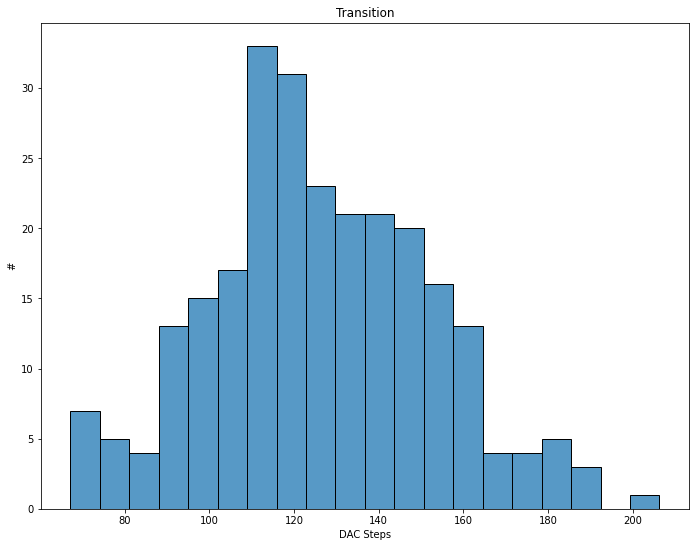

In [48]:
Histograms_1D(station, load, ectype, "Transition")

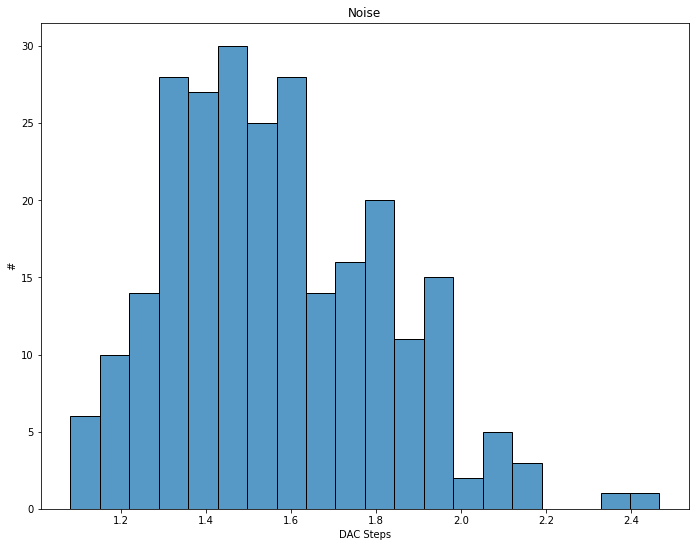

In [49]:
Histograms_1D(station, load, ectype, "Noise")